In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os
from tqdm.notebook import tqdm
import random
import time

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from tensorflow import keras

from tensorflow.python.keras.models import Sequential,Input,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

2022-06-25 01:55:41.174631: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/schmid/.platformio/penv/lib/python3.10/site-packages/cv2/../../lib64:
2022-06-25 01:55:41.174667: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print('test')

test


In [3]:
PATH_DRAW = '../out/2022-06-24/draw/'
PATH_HOVER = '../out/2022-06-24/hover/'

#DRAW_PATHS = [PATH_DRAW, PATH_DRAW_NEW, PATH_DRAW_SUNLIGHT]
#HOVER_PATHS = [PATH_HOVER, PATH_HOVER_NEW, PATH_HOVER_SUNLIGHT]

#for exposure in [2500, 2000, 1500, 1000]:
#    gain = int(exposure / 10)
#    DRAW_PATHS.append(f'../out/draw_{exposure}_{gain}')
#    HOVER_PATHS.append(f'../out/hover_{exposure}_{gain}')
        

IMG_SIZE = 48

In [4]:
def crop_image(img, size = 16):
    margin = int(size / 2)
    _, brightest, _, (max_x, max_y) = cv2.minMaxLoc(img)
    img_cropped = img[max_y - margin : max_y + margin, max_x - margin : max_x + margin]
    return img_cropped, (max_x, max_y)

In [5]:
def crop_image_2(img, size = 16):
    tmp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    margin = int(size / 2)
    brightest = int(np.max(tmp))
    _, thresh = cv2.threshold(tmp, brightest - 1, 255, cv2.THRESH_BINARY)
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    #print(contours)
    
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    x_values = []
    y_values = []
    for cnt in contours:
        for point in cnt:
            point = point[0]
            #print(point)
            x_values.append(point[0])
            y_values.append(point[1])
    
    #print('x', np.max(x_values), np.min(x_values))
    #print('y', np.max(y_values), np.min(y_values))
    d_x = np.max(x_values) - np.min(x_values)
    d_y = np.max(y_values) - np.min(y_values)
    center_x = int(np.min(x_values) + d_x / 2)
    center_y = int(np.min(y_values) + d_y / 2)
    #print(center_x, center_y)
    
    left = np.max([0, center_x - margin])
    top = np.max([0, center_y - margin])
    
    #print(left, top)
    
    if left + size >= tmp.shape[1]:
        #left -= (left + size - img.shape[1] - 1)
        left = tmp.shape[1] - size - 1
    if top + size >= tmp.shape[0]:
        #top -= (top + size - img.shape[0] - 1)
        top = tmp.shape[0] - size - 1
    
    #_, brightest, _, (max_x, max_y) = cv2.minMaxLoc(img)
    img_cropped = img[top : top + size, left : left + size]
    return img_cropped, (left + margin, top + margin)



hover_314_2500_32.png


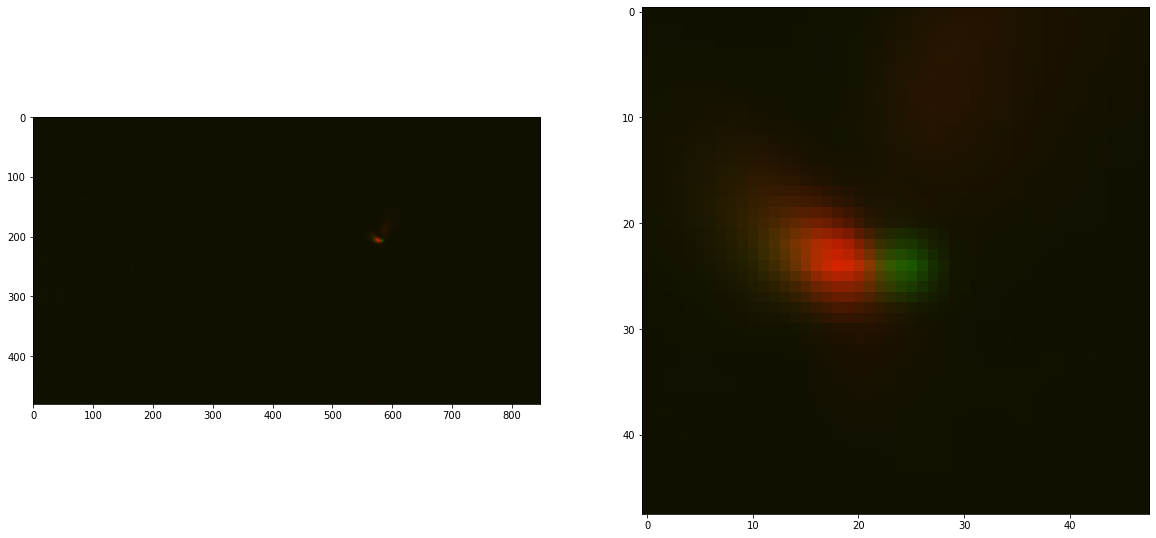

In [8]:
fname = random.sample(os.listdir(PATH_HOVER), 1)[0]
print(fname)
img = cv2.imread(PATH_HOVER + '/' + fname)
img_cropped, _ = crop_image_2(img, IMG_SIZE)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img, 'gray')
axes[1].imshow(img_cropped, 'gray')

hover_32_5000_64.png


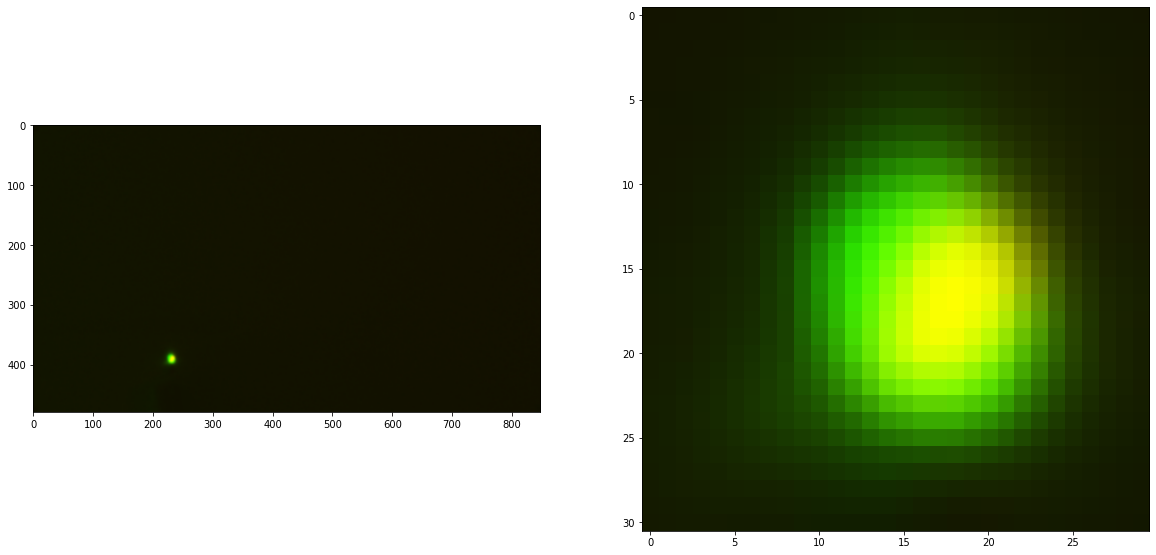

In [122]:
def crop_to_nonblack(img, size = 16):
    tmp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    margin = int(size / 2)
    (image_height, image_width) = tmp.shape
    step_w = int(image_width / 10)
    step_h = int(image_height / 10)

    samples = []
    for x in range(2 * step_w, (image_width - 2 * step_w), step_w):
        for y in range(2 * step_h, (image_height - 2 * step_h), step_h):
            samples.append(tmp[y, x])
    _, thresh = cv2.threshold(tmp, np.median(samples) * 1.5, 255, cv2.THRESH_BINARY)
    #contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #contours = contours[0] if len(contours) == 2 else contours[1]
    (x, y, w, h) = cv2.boundingRect(thresh)
    #result = img[y:y+h, x:x+w]
    center_x = int(x + w / 2)
    center_y = int(y + h / 2)
    left = np.max([0, center_x - margin])
    top = np.max([0, center_y - margin])
    if left + size >= tmp.shape[1]:
        #left -= (left + size - img.shape[1] - 1)
        left = tmp.shape[1] - size - 1
    if top + size >= img.shape[0]:
        #top -= (top + size - img.shape[0] - 1)
        top = tmp.shape[0] - size - 1
    #img_cropped = img[top : top + size, left : left + size]
    img_cropped = img[y:y+h, x:x+w]
    return img_cropped, (left + margin, top + margin)
    
fname = random.sample(os.listdir(PATH_HOVER), 1)[0]
print(fname)
img = cv2.imread(PATH_HOVER + '/' + fname)
img_cropped, _ = crop_to_nonblack(img, IMG_SIZE)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img, 'gray')
axes[1].imshow(img_cropped, 'gray')

In [6]:
def read_images(path):
    files = os.listdir(path)
    files = [file for file in files if file[-4:] == ".png"]
    
    images = []
    coords = []
    
    size = IMG_SIZE
    
    for file in tqdm(files):
        try:
            image = cv2.imread(os.path.join(path, file))
            #image = cv2.resize(image, (36,36), cv2.INTER_AREA)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            #image = data_augmentation(image)
            
            #image, (max_x, max_y) = crop_image(image, size)
            image, (max_x, max_y) = crop_image_2(image, size)
            #print(np.max(image))
            if image.shape == (size, size, 3) and np.max(image) > 200:
                images.append(image)
                coords.append((max_x, max_y))
            
        except OSError:
            pass
    
    return images, coords

In [7]:
def data_augmentation(images):
    result = []
    for img in images:
        result.append(img[:,:,:2])
        result.append(cv2.flip(img, flipCode=0)[:,:,:2])
        for i in range(3):
            tmp = cv2.rotate(img, i)
            for b in range(7, 12):
                tmp2 = np.clip(tmp * (b / 10), 0, 255) / 255
                #tmp2 = tmp * (b / 10)
                result.append(tmp2[:,:,:2])
                result.append(cv2.flip(tmp2, flipCode=0)[:,:,:2])
    return result

hover_225_2500_32.png


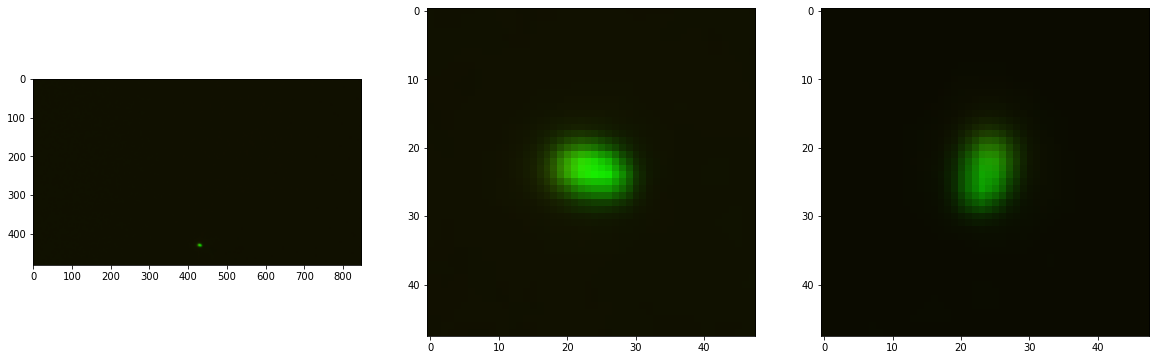

In [67]:
fname = random.sample(os.listdir(PATH_HOVER), 1)[0]
print(fname)
img = cv2.imread(PATH_HOVER + '/' + fname)
img_cropped, _ = crop_image_2(img, IMG_SIZE)
#print(img_cropped)
#img_cropped = np.clip(img_cropped * 0.9, 0, 255) / 255
#print(img_cropped)
augmented = data_augmentation([img_cropped])
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(img, 'gray')
axes[1].imshow(img_cropped, 'gray')
axes[2].imshow(augmented[2], 'gray')

0596_draw_1896_30.png
253


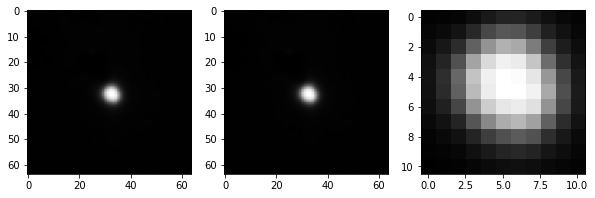

In [358]:
fname = random.sample(os.listdir(PATH_DRAW_NEW), 1)[0]
print(fname)
img = cv2.imread(PATH_DRAW_NEW + '/' + fname, cv2.IMREAD_GRAYSCALE)
#img = cv2.imread(PATH_DRAW + '0024.png', cv2.IMREAD_GRAYSCALE)
#print(img.shape)
img_cropped, coords = crop_image_2(img, IMG_SIZE)
print(np.max(img_cropped))
#print(coords)

img_cropped_2, _ = crop_image(img, IMG_SIZE)

img_cropped_3, _ = crop_to_nonblack(img, IMG_SIZE)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

#img = cv2.rectangle(img, (coords[0] - int(IMG_SIZE / 2), coords[1] - int(IMG_SIZE / 2)), (coords[0] + int(IMG_SIZE / 2), coords[1] + int(IMG_SIZE / 2)), (255), 1)
#print(img_cropped[0, 0])
#print(img_cropped.shape)
axes[0].imshow(img_cropped, 'gray')

axes[1].imshow(img_cropped_2, 'gray')

axes[2].imshow(img_cropped_3, 'gray')

0150_hover_2602_193.png
248


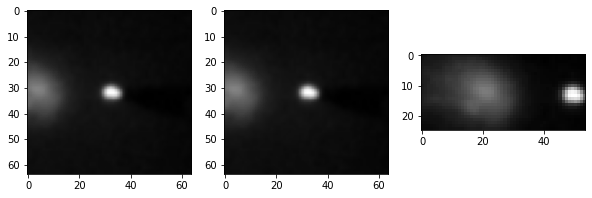

In [346]:
fname = random.sample(os.listdir(PATH_HOVER_NEW), 1)[0]
print(fname)
img = cv2.imread(PATH_HOVER_NEW + '/' + fname, cv2.IMREAD_GRAYSCALE)
#img = cv2.imread(PATH_DRAW + '0024.png', cv2.IMREAD_GRAYSCALE)
#print(img.shape)
img_cropped, coords = crop_image_2(img, IMG_SIZE)
print(np.max(img_cropped))
#print(coords)

img_cropped_2, _ = crop_image(img, IMG_SIZE)

img_cropped_3, _ = crop_to_nonblack(img, IMG_SIZE)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

#img = cv2.rectangle(img, (coords[0] - int(IMG_SIZE / 2), coords[1] - int(IMG_SIZE / 2)), (coords[0] + int(IMG_SIZE / 2), coords[1] + int(IMG_SIZE / 2)), (255), 1)
#print(img_cropped[0, 0])
#print(img_cropped.shape)
axes[0].imshow(img_cropped, 'gray')

axes[1].imshow(img_cropped_2, 'gray')

axes[2].imshow(img_cropped_3, 'gray')

In [8]:
images_draw, _ = read_images(PATH_DRAW)
images_hover, _ = read_images(PATH_HOVER)

images_draw = data_augmentation(images_draw)
images_hover = data_augmentation(images_hover)
images = images_draw + images_hover
labels = [0] * len(images_draw) + [1] * len(images_hover)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

TypeError: Invalid shape (48, 48, 2) for image data

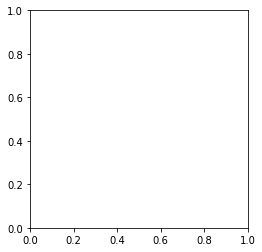

In [23]:
#plt.imshow(random.sample(images, 1)[0][:,:,:2])

In [28]:
random.sample(images, 1)[0][:,:,:2]

array([[[0.05333333, 0.05019608],
        [0.05019608, 0.05019608],
        [0.05019608, 0.05333333],
        ...,
        [0.05019608, 0.05019608],
        [0.05019608, 0.05019608],
        [0.05019608, 0.05019608]],

       [[0.05333333, 0.05019608],
        [0.05333333, 0.05019608],
        [0.05019608, 0.05333333],
        ...,
        [0.05019608, 0.05019608],
        [0.05019608, 0.05019608],
        [0.05019608, 0.05019608]],

       [[0.05333333, 0.05019608],
        [0.05333333, 0.05019608],
        [0.05333333, 0.05333333],
        ...,
        [0.05333333, 0.05333333],
        [0.05333333, 0.05019608],
        [0.05019608, 0.05019608]],

       ...,

       [[0.05333333, 0.05019608],
        [0.05019608, 0.05019608],
        [0.05019608, 0.05019608],
        ...,
        [0.05333333, 0.05019608],
        [0.05333333, 0.05019608],
        [0.05333333, 0.05019608]],

       [[0.05333333, 0.05019608],
        [0.05019608, 0.05019608],
        [0.05019608, 0.05019608],
        .

In [9]:
train_X = np.array(images)
train_Y = np.array(labels)

print('Training data shape : ', train_X.shape, train_Y.shape)

Training data shape :  (88992, 48, 48, 2) (88992,)


In [10]:
train_Y_one_hot = to_categorical(train_Y)

In [11]:
train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

train_X = train_X.reshape(-1, IMG_SIZE, IMG_SIZE, 2)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(71193, 48, 48, 2) (17799, 48, 48, 2) (71193, 2) (17799, 2)


In [12]:
unique, counts = np.unique(valid_label, return_counts=True)
dict(zip(unique, counts))

{0.0: 17799, 1.0: 17799}

## Batch Size

tried 4 -- 64, does not make a big difference

## Activation Function

relu is 3% better than linear, sigmoid, tanh

## Number of Dense Layers

3 and 5 are good

## Number of Neurons per Dense Layer

16 -- 256 makes almost no difference, but 128 is slightly better

## Number of Convolution Layers (1st param decreasing, kernel size increasing)

1 -- 3 is good, but almost no difference

## Epochs

more than one is fine

In [ ]:
#Settings

batch_size = 32
epochs = 3
num_classes = 2
activation = 'relu'
layer_count = 5
num_neurons = 128

#for epochs in range(1, 7):
    #print(f'+++++ EPOCHS: {epochs} +++++')
#Define model structure
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3),activation='linear',input_shape=(IMG_SIZE,IMG_SIZE,2),padding='same'))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (5, 5), activation='linear',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(32, (7, 7), activation='linear',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(16, (9, 9), activation='linear',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
#model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))                 
#model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())

# trial and error: linear performs much better than ReLU and sigmoid
for i in range(layer_count):
    model.add(Dense(num_neurons, activation=activation))
#model.add(Dense(64, activation=activation))
#model.add(Dense(64, activation=activation))
#model.add(Dense(128, activation='linear'))
#model.add(Dense(128, activation='linear'))

# classifier
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.metrics.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

history = model.fit(
    train_X, 
    train_label, 
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(valid_X, valid_label)
)

2022-06-25 02:37:37.559136: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1312229376 exceeds 10% of free system memory.


Epoch 1/3
 173/2225 [=>............................] - ETA: 15:43 - loss: 1.1139 - accuracy: 0.5378

In [ ]:
model.save('hover_predictor_stereo_twochannel_1')

In [366]:
test_images_draw, _ = read_images(PATH_TEST_DRAW)
test_images_hover, _ = read_images(PATH_TEST_HOVER)
test_images = test_images_draw + test_images_hover
print(len(test_images))

/tmp/ipykernel_222420/1043679742.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(files):


  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

302


In [407]:
predictions_draw = []
predictions_hover = []
confidences_draw = []
confidences_hover = []

for i in test_images_draw:
    img = i.astype('float32') / 255
    img = img.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    prediction = model.predict(img)
    predictions_draw.append(np.argmax(prediction))
    confidences_draw.append(prediction[0][0])
    
for i in test_images_hover:
    img = i.astype('float32') / 255
    img = img.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    prediction = model.predict(img)
    predictions_hover.append(np.argmax(prediction))
    confidences_hover.append(prediction[0][1])

In [408]:
print(1 - np.mean(predictions_draw), np.mean(confidences_draw))
print(np.mean(predictions_hover), np.mean(confidences_hover))

0.0 8.564023e-19
1.0 1.0


In [355]:
def predict(img):
    img = img.astype('float32') / 255
    img = img.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    prediction = model.predict(img)
    return prediction

hover
[[2.3264135e-04 9.9976736e-01]]


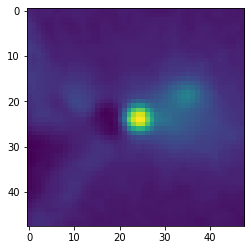

In [363]:
idx = random.randint(0, len(test_images) - 1)
test_image = test_images[idx]
#print(test_image)
if idx > len(test_images_draw):
    print('hover')
else:
    print('draw')
print(predict(test_image))
plt.imshow(test_image)

In [323]:
WRITE_PATH = '../out/write'
test_images_write, coords = read_images(WRITE_PATH)

/tmp/ipykernel_222420/1043679742.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(files):


  0%|          | 0/395 [00:00<?, ?it/s]

In [265]:
coords = np.array(coords)

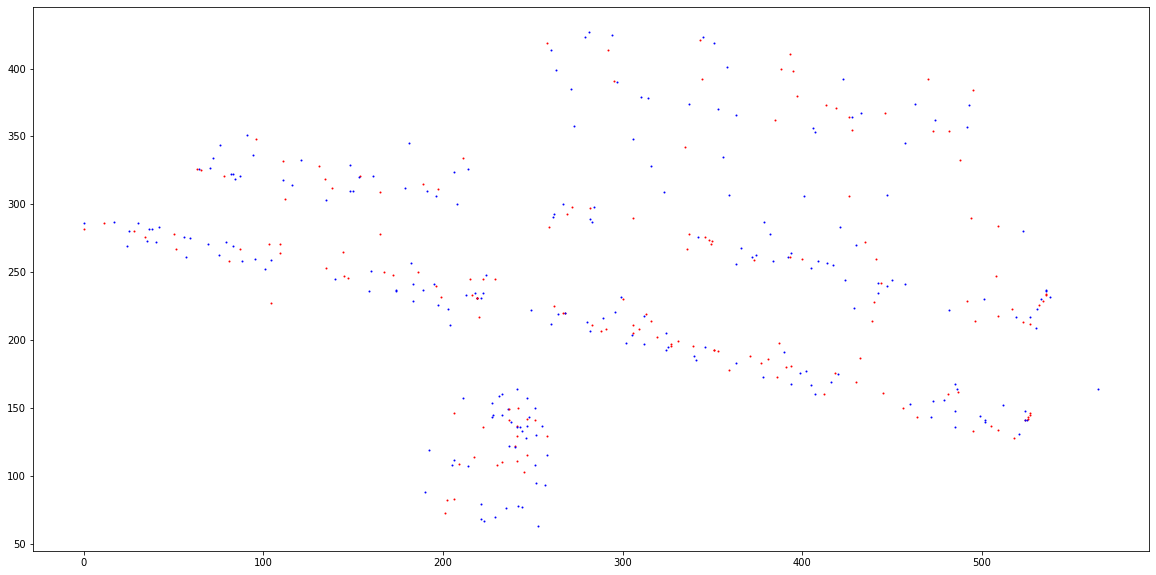

In [357]:
plt.figure(figsize = (20, 10))
for i in range(1, len(test_images_write)):
    pred = np.argmax(predict(test_images_write[i]))
    
    color = 'red' if pred == 1 else 'blue'
    plt.scatter(coords[i][0], coords[i][1], s=1, c=color)
    #plt.plot((coords[i-1][0], coords[i][0]), (coords[i-1][1], coords[i][1]), c=color)
#plt.scatter(coords.T[0], coords.T[1], s=1, c=color)

[[9.991322e-01 8.678388e-04]]


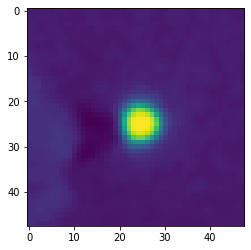

In [333]:
idx = random.randint(0, len(test_images_write) - 1)
test_image = test_images_write[idx]
#print(test_image)

print(predict(test_image))
plt.imshow(test_image)

draw
[[0.84201366 0.15798642]]


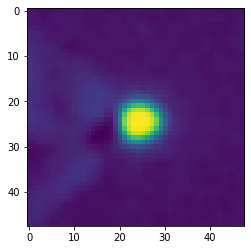

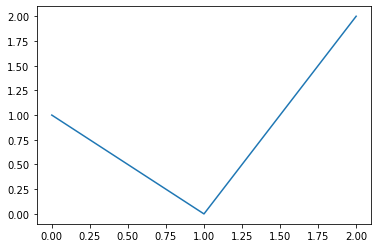

In [347]:
plt.plot((0,1, 2), (1,0, 2))